In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import fastcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from timeit import default_timer as timer
from sklearn.linear_model import LinearRegression
import math
# import json
# with open('510050_20230214.json') as user_file:
#   parsed_json = json.load(user_file)
# tickers = []
# for i in parsed_json["StockComponent"].keys():
#   tickers.append(i+".SH")

import tushare as ts
ts.set_token('bdb08afc499e166575426cccc5aae85ae04cdb4196cd512ef310d04e')
pro = ts.pro_api()
tickers = ['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH', '600031.SH', '600036.SH', '600048.SH', '600050.SH', '600104.SH', '600196.SH', '600276.SH', '600309.SH', '600438.SH', '600519.SH', '600547.SH', '600570.SH', '600585.SH', '600588.SH', '600690.SH', '600703.SH', '600745.SH', '600809.SH', '600837.SH', '600887.SH', '600893.SH', '600918.SH', '601012.SH', '601066.SH', '601088.SH', '601138.SH', '601166.SH', '601211.SH', '601288.SH', '601318.SH', '601336.SH', '601398.SH', '601601.SH', '601628.SH', '601668.SH', '601688.SH', '601818.SH', '601857.SH', '601888.SH', '601899.SH', '601995.SH', '603259.SH', '603288.SH', '603501.SH', '603986.SH']

                      
def get_returns(tickers, start, end):
    stocks = pro.daily(ts_code=tickers[0], start_date=start, end_date=end, fields=['trade_date'])
    for ticker in tickers:
        stock = pro.daily(ts_code=ticker, start_date=start, end_date=end, fields=['trade_date', 'close'])
        stock = stock.rename(columns={"close" : ticker})
        stocks = stocks.merge(stock,on=['trade_date'])
    stocks.set_index(['trade_date'], inplace=True)
    stocks = stocks.iloc[::-1]
    stocks = stocks.dropna()
    returns = stocks.pct_change().iloc[1:] # (pre_close - close)/pre_close
    return returns

In [ ]:
# 函数correlations 输入标准化的returns, nb_clusters 返回sorted_correlations, HPCA_corr, sorted_returns
def correlations(returns, nb_clusters):
    ### 分层聚类--使得相关系数大的股票离得更近
    corr = returns.corr(method='pearson')   #股票returns的相关系数
    dist = 1 - corr.values
    tri_a, tri_b = np.triu_indices(len(dist), k=1)
    linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward') # 最短最长平均法做层次聚类
    permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(linkage, dist[tri_a, tri_b])) # 重新排序切割树 得到叶节点
    sorted_stocks = returns.columns[permutation]
    sorted_corrs = corr.values[permutation, :][:, permutation]
    sorted_correlations = pd.DataFrame(sorted_corrs, index=sorted_stocks, columns=sorted_stocks) # 层次聚类排序后的股票相关系数 靠近斜对角线的系数更大，对应股票相关性更强 

    ### 根据sorted_correlations将股票分成若干簇  注意！如果没有明显的资产分组，HPCA会加强一个虚假的结构
    dist = 1 - sorted_correlations.values
    dim = len(dist)
    tri_a, tri_b = np.triu_indices(dim, k=1)
    linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
    clustering_inds = hierarchy.fcluster(linkage, nb_clusters,
                                        criterion='maxclust')
    clusters = {i: [] for i in range(min(clustering_inds),
                                    max(clustering_inds) + 1)}
    for i, v in enumerate(clustering_inds):
        clusters[v].append(i)

    permutation = sorted([(min(elems), c) for c, elems in clusters.items()],
                        key=lambda x: x[0], reverse=False)
    sorted_clusters = {}
    for cluster in clusters:
        sorted_clusters[cluster] = clusters[permutation[cluster - 1][1]]
    # 画每簇的成员股票累计收益率 簇内股票收益率相关性强 累计收益率曲线相似 注意！若相关系数不大，曲线不相似，可以增大簇的个数
    stock_to_cluster = {}
    for cluster in sorted_clusters:
        cluster_members = sorted_correlations.columns[sorted_clusters[cluster]].tolist()
        for stock in cluster_members:
            stock_to_cluster[stock] = cluster
    ### 簇内股票收益率矩阵 右乘 簇内相关系数矩阵的第一特征向量 除以 最大特征值的平方 得收益率降维后的值
    eigen_clusters = {}
    for cluster in clusters:
        cluster_members = sorted_correlations.columns[
            sorted_clusters[cluster]].tolist()
        corr_cluster = sorted_correlations.loc[
            cluster_members, cluster_members]
        cluster_returns = returns[cluster_members]
        eigenvals, eigenvecs = np.linalg.eig(corr_cluster.values) # 簇内相关系数的特征值、特征向量
        idx = eigenvals.argsort()[::-1]
        eigenvals, eigenvecs = eigenvals[idx], eigenvecs[:, idx]
        val1, vec1= eigenvals[0], eigenvecs[:, 0] # 簇内相关系数的最大特征值、第一特征向量
        F1 = (1 / np.sqrt(val1)) * np.dot(cluster_returns.values,vec1) # 得簇内收益率降维后的值 392*10 × 10*1 = 392*1  将股票收益率整合到方差最大的线性方向上
        eigen_clusters[cluster] = F1
    # 股票收益率和对应簇内降维收益率的线性回归斜率
    betas = {}
    for stock in returns.columns:
        stock_returns = returns[stock]
        cluster_F1 = eigen_clusters[stock_to_cluster[stock]]
        reg = LinearRegression(fit_intercept=False).fit(
            cluster_F1.reshape(-1, 1), stock_returns)
        beta = reg.coef_[0]
        betas[stock] = beta 
    ### 更新不同簇的股票之间的相关系数 体现出簇间相关性
    HPCA_corr = sorted_correlations.copy()
    for stock_1 in HPCA_corr.columns:
        beta_1 = betas[stock_1]
        F1_1 = eigen_clusters[stock_to_cluster[stock_1]]
        for stock_2 in HPCA_corr.columns:
            beta_2 = betas[stock_2]
            F1_2 = eigen_clusters[stock_to_cluster[stock_2]]
            if stock_to_cluster[stock_1] != stock_to_cluster[stock_2]: # 对不同簇股票的相关系数调整 体现簇间差异
                rho_sector = np.corrcoef(F1_1, F1_2)[0, 1] # 簇间相关性
                mod_rho = beta_1 * beta_2 * rho_sector
                HPCA_corr.at[stock_1, stock_2] = mod_rho
    return sorted_correlations, HPCA_corr

In [ ]:
start = '20200301'
end = '20230407'
history_returns = get_returns(tickers, start, end)

In [ ]:
cur_ret_P = []
cur_ret__ = []
cum_ret_P = [0]
cum_ret__ = [0]
date = []
window_length = 252

n_component = 50
# 获取标准化实验数据
original_returns = history_returns.iloc[:window_length]
returns = (original_returns - original_returns.mean())/original_returns.std()

eigenvals_P, eigenvecs_P = np.linalg.eig(returns.corr())
idx_P = eigenvals_P.argsort()[::-1]   
pca_eigenvecs = eigenvecs_P[:, idx_P][:, :n_component]  
fct_P = np.dot(original_returns,pca_eigenvecs)
OLSmodels_P = {stock: sm.OLS(original_returns[stock], fct_P).fit() for stock in original_returns.columns}
beta_P = pd.DataFrame({stock: model_P.params for stock, model_P in OLSmodels_P.items()})
zscores = pd.DataFrame(np.zeros([321,50]), index=history_returns.index[window_length:-1],columns=history_returns.columns)

for cur_num in range(window_length, history_returns.shape[0]-1):
    date.append(history_returns.index[cur_num])
    print('date:', date[-1])
    cur_returns = history_returns.iloc[cur_num]
    zscores_P = cur_returns - cur_returns.dot(np.array(pca_eigenvecs)).dot(beta_P)
    zscores.loc[date] += zscores_P

    long_P = zscores_P.sort_values()[:3]
    short_P = zscores_P.sort_values()[-3:]

    # PCA选股
    print('PCA：', end='')
    if len(long_P) != 0:
        weights_long_P =  long_P * (1 / long_P.sum())
    else: weights_long_P = long_P
    if len(short_P) != 0:
        weights_short_P =  short_P * (1 / short_P.sum())
    else: weights_short_P = short_P
    cur_ret_P.append((sum(weights_long_P*history_returns[weights_long_P.index].iloc[cur_num+1]) - sum(weights_short_P*history_returns[weights_short_P.index].iloc[cur_num+1]))/2 - history_returns.iloc[cur_num].mean())
    cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
    cur_ret__.append(history_returns.iloc[cur_num+1].mean())
    cum_ret__.append((1+cum_ret__[-1])*(1+cur_ret__[-1])-1)
    print('cur ret：%.4f'%cur_ret_P[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_P[-1])
    ########################################################

df_cur = pd.DataFrame(np.array([cur_ret_P[:],cur_ret__[:]]).T, columns=['PCA alpha','beta'], index=np.array(date))
df_cur.plot()
plt.title('cur ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()
df_cum = pd.DataFrame(np.array([cum_ret_P[1:],cum_ret__[1:]]).T, columns=['PCA alpha','beta'], index=np.array(date))
df_cum.plot()
plt.title('cum ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()

In [ ]:
df_cum.tail(20)

In [ ]:
# 不做空策略
cur_ret_P = []
cur_ret_H = []
cur_ret__ = []
cur_ret_ = []
cum_ret_P = [0]
cum_ret_H = [0]
cum_ret__ = [0]
cum_ret_ = [0]

date = []
window_length = 200
nb_cluster = 19
n_component = 40
for cur_num in range(window_length, history_returns.shape[0]):
    date.append(history_returns.index[cur_num-1])
    print('date:', date[-1])
    # 获取标准化实验数据
    original_returns = history_returns.iloc[cur_num-window_length:cur_num]
    returns = (original_returns - original_returns.mean())/original_returns.std()
    sorted_correlations, HPCA_corr = correlations(returns,nb_cluster)
    sorted_returns = original_returns[sorted_correlations.columns] 
    eigenvals_P, eigenvecs_P = np.linalg.eig(sorted_correlations)
    idx_P = eigenvals_P.argsort()[::-1]   
    pca_eigenvecs = eigenvecs_P[:, idx_P][:, :n_component]  
    fct_P = np.dot(sorted_returns/sorted_returns.std(),pca_eigenvecs)
    OLSmodels_P = {stock: sm.OLS(sorted_returns[stock], fct_P).fit() for stock in sorted_returns.columns}
    resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
    zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1]
    long_P = zscores_P[zscores_P < -1.5]

    eigenvals_H, eigenvecs_H = np.linalg.eig(HPCA_corr)
    idx_H = eigenvals_H.argsort()[::-1]   
    hpca_eigenvecs = eigenvecs_H[:, idx_H][:, :n_component]  
    fct_H = np.dot(sorted_returns/sorted_returns.std(),hpca_eigenvecs)
    OLSmodels_H = {stock: sm.OLS(sorted_returns[stock], fct_H).fit() for stock in sorted_returns.columns}
    resids_H = pd.DataFrame({stock: model_H.resid for stock, model_H in OLSmodels_H.items()}) 
    zscores_H = ((resids_H - resids_H.mean()) / resids_H.std()).iloc[-1]
    long_H = zscores_H[zscores_H < -1.5]
    ########################################################
    # HPCA选股
    print('HPCA：', end='')
    if len(long_H) != 0:
        weights_long_H = long_H * (1 / long_H.sum())
        print('long:', end=' ')
        for stock, weight in weights_long_H.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_long_H = long_H
    cur_ret_H.append(sum(weights_long_H*history_returns[weights_long_H.index].iloc[cur_num]) - history_returns.iloc[cur_num].mean())
    cum_ret_H.append((1+cum_ret_H[-1])*(1+cur_ret_H[-1])-1)
    print('cur ret：%.4f'%cur_ret_H[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_H[-1])
    # PCA选股
    print('PCA：', end='')
    if len(long_P) != 0:
        weights_long_P =  long_P * (1 / long_P.sum())
        print('long:', end=' ')
        for stock, weight in weights_long_P.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_long_P = long_P
    cur_ret_P.append(sum(weights_long_P*history_returns[weights_long_P.index].iloc[cur_num]) - history_returns.iloc[cur_num].mean())
    cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
    cur_ret__.append(history_returns.iloc[cur_num].mean())
    cum_ret__.append((1+cum_ret__[-1])*(1+cur_ret__[-1])-1)
    print('cur ret：%.4f'%cur_ret_P[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_P[-1])
    # 交叉选股
    print('hpca&pca', end=' ')
    if len(long_P.index.intersection(long_H.index)) == 0:
        cur_ret_.append(- history_returns.iloc[cur_num].mean())
    else:
        cur_ret_.append(history_returns[long_P.index.intersection(long_H.index)].iloc[cur_num].mean() - history_returns.iloc[cur_num].mean())
    cum_ret_.append((1+cum_ret_[-1])*(1+cur_ret_[-1])-1)
    print('cur ret：%.4f'%cur_ret_[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_[-1])
    ########################################################


df_cur = pd.DataFrame(np.array([cur_ret_P[:],cur_ret_H[:],cur_ret_[:],cur_ret__[:]]).T, columns=['PCA alpha','HPCA alpha','hpca&pca alpha','beta'], index=np.array(date))
df_cur.plot()
plt.title('cur ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()
df_cum = pd.DataFrame(np.array([cum_ret_P[1:],cum_ret_H[1:],cum_ret_[1:],cum_ret__[1:]]).T, columns=['PCA alpha','HPCA alpha','hpca&pca alpha','beta'], index=np.array(date))
df_cum.plot()
plt.title('cum ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()

In [2]:
# SR2307白糖

df = pro.fut_daily(ts_code='TF.CFX')
df.set_index(['trade_date'], inplace=True)
SR = df['settle'].sort_index()

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '20230315'),
  Text(0.0, 0, '20221115'),
  Text(20.0, 0, '20221213'),
  Text(40.0, 0, '20230111'),
  Text(60.0, 0, '20230215'),
  Text(80.0, 0, '20230315'),
  Text(100.0, 0, ''),
  Text(120.0, 0, '')])

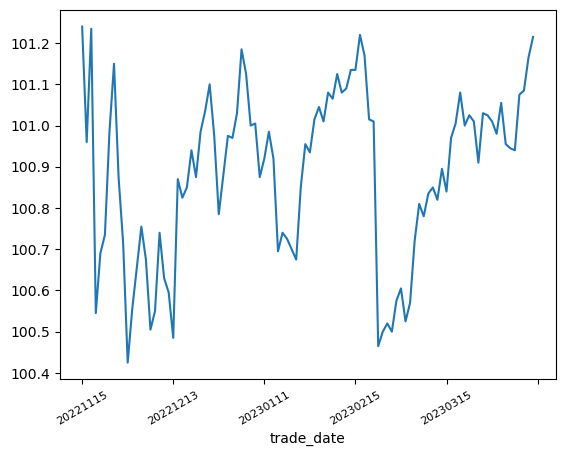

In [4]:
SR.iloc[-100:].plot()
plt.xticks(rotation=30, fontsize=8)

In [17]:
max(1,2,3+1)

4